# How to classify satellite images

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from sklearn.datasets import load_files       
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam

import tensorflow_datasets as tfds

In [3]:
sns.set_style('whitegrid')

## Load EuroSat Dataset

In [4]:
(raw_train, raw_validation), metadata = tfds.load(
    'eurosat',
    split=[
       tfds.Split.TRAIN.subsplit(tfds.percent[:90]),
       tfds.Split.TRAIN.subsplit(tfds.percent[90:])
],
    with_info=True,
    shuffle_files=False,
    as_supervised=True,
)

### Inspect MetaData

In [5]:
metadata

tfds.core.DatasetInfo(
    name='eurosat',
    version=0.0.1,
    description='EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
bands and consisting of 10 classes with 27000 labeled and
geo-referenced samples.

Two datasets are offered:
- rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
- all: Contains all 13 bands in the original value range (float32).

URL: https://github.com/phelber/eurosat
',
    urls=['https://github.com/phelber/eurosat'],
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=27000,
    splits={
        'train': 27000,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{helber2017eurosat,
        title={EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification},
       

In [6]:
print('Train:\t', raw_train)
print('Valid:\t', raw_validation)

Train:	 <_OptionsDataset shapes: ((64, 64, 3), ()), types: (tf.uint8, tf.int64)>
Valid:	 <_OptionsDataset shapes: ((64, 64, 3), ()), types: (tf.uint8, tf.int64)>


### Show sample images

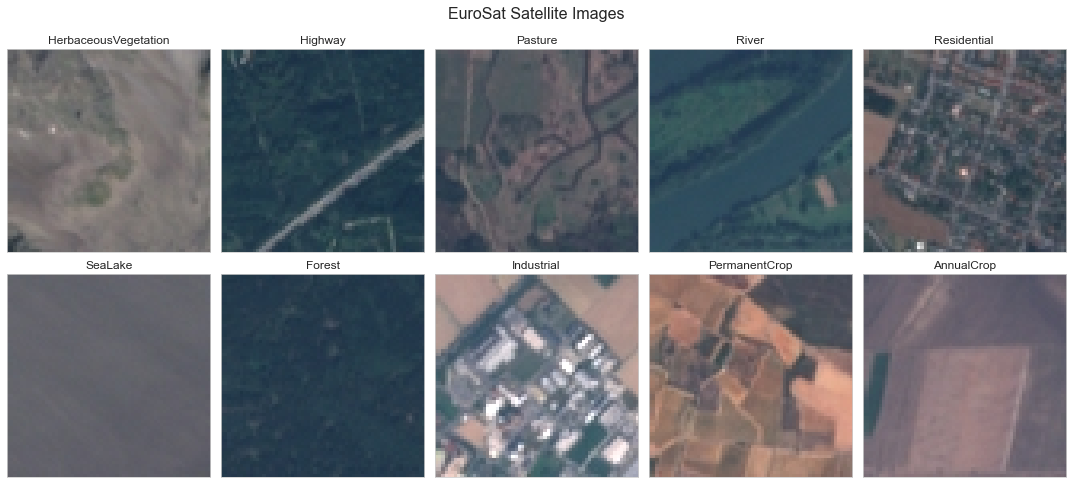

In [7]:
fig, axes = plt.subplots(figsize=(15, 7), ncols=5, nrows=2)
axes = axes.flatten()
get_label_name = metadata.features['label'].int2str
labels = set()
c = 0
for img, label in raw_train.as_numpy_iterator():
    if label not in labels:
        axes[c].imshow(img)
        axes[c].set_title(get_label_name(label))
        axes[c].grid(False)
        axes[c].tick_params(axis='both', 
                            which='both', 
                            bottom=False, 
                            top=False, 
                            labelbottom=False, 
                            right=False, 
                            left=False, 
                            labelleft=False)
        labels.add(label)
        c += 1
        if c == 10:
            break
fig.suptitle('EuroSat Satellite Images', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=.92)
fig.savefig('figures/eurosat');

## Preprocessing

All images will be resized to 160x160:

In [8]:
IMG_SIZE = 64
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [9]:
def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    return image, label

In [10]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)

In [11]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [12]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)

In [13]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

TensorShape([32, 64, 64, 3])

## Load the DenseNet201 Bottleneck Features

In [14]:
densenet = DenseNet201(input_shape=IMG_SHAPE, 
                       include_top=False, 
                       weights='imagenet',
                       pooling='max',
                       input_shape=None,
                       classes=1000)

densenet.summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [15]:
feature_batch = densenet(image_batch)
feature_batch.shape

TensorShape([32, 1920])

In [16]:
len(densenet.layers)

708

## Add new layers to model

In [17]:
model = Sequential([
    densenet,
    BatchNormalization(),
    Dense(2048, activation='relu', kernel_regularizer=l1_l2(0.01)),
    BatchNormalization(),
    Dense(2048, activation='relu', kernel_regularizer=l1_l2(0.01)),
    BatchNormalization(),
    Dense(2048, activation='relu', kernel_regularizer=l1_l2(0.01)),
    BatchNormalization(),
    Dense(2048, activation='relu', kernel_regularizer=l1_l2(0.01)),
    BatchNormalization(),
    Dense(10, activation='softmax')
])

In [18]:
for layer in model.layers:
    layer.trainable = True

In [19]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(lr=1e-4),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 1920)              18321984  
_________________________________________________________________
batch_normalization (BatchNo (None, 1920)              7680      
_________________________________________________________________
dense (Dense)                (None, 2048)              3934208   
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_2 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              4

### Compute baseline metrics

In [21]:
initial_epochs = 10
validation_steps = 20

initial_loss, initial_accuracy = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 13s 650ms/step - loss: 3256.1112 - accuracy: 0.0500


In [22]:
print(f'Initial loss: {initial_loss:.2f} | initial_accuracy accuracy: {initial_accuracy:.2%}')

Initial loss: 3256.11 | initial_accuracy accuracy: 5.00%


## Train model

### Define Callbacks

In [23]:
early_stopping = EarlyStopping(monitor='val_accuracy', 
                               patience=10)

In [24]:
eurosat_path = 'models/eurosat.cnn.weights.best.hdf5'
checkpointer = ModelCheckpoint(filepath=eurosat_path,
                               verbose=1,
                               monitor='val_accuracy',
                               save_best_only=True)

In [25]:
epochs = 100

In [26]:
history = model.fit(train_batches,
                    epochs=epochs,
                    validation_data=validation_batches,
                    callbacks=[checkpointer, 
                               early_stopping])

Epoch 1/100
    760/Unknown - 1082s 1s/step - loss: 705.5719 - accuracy: 0.8133
Epoch 00001: val_accuracy improved from -inf to 0.91037, saving model to models/eurosat.cnn.weights.best.hdf5
760/760 [==============================] - 1114s 1s/step - loss: 705.5726 - accuracy: 0.8133 - val_loss: 4.1639 - val_accuracy: 0.9104
Epoch 2/100
759/760 [============================>.] - ETA: 1s - loss: 2.5807 - accuracy: 0.9208
Epoch 00002: val_accuracy improved from 0.91037 to 0.94185, saving model to models/eurosat.cnn.weights.best.hdf5
760/760 [==============================] - 1007s 1s/step - loss: 2.5826 - accuracy: 0.9207 - val_loss: 2.3222 - val_accuracy: 0.9419
Epoch 3/100
759/760 [============================>.] - ETA: 1s - loss: 2.3690 - accuracy: 0.9503
Epoch 00003: val_accuracy improved from 0.94185 to 0.97222, saving model to models/eurosat.cnn.weights.best.hdf5
760/760 [==============================] - 1027s 1s/step - loss: 2.3688 - accuracy: 0.9503 - val_loss: 2.1056 - val_accura

### Plot Learning Curves

In [27]:
def plot_learning_curves(df):
    fig, axes = plt.subplots(ncols=2, figsize=(15, 4))
    df[['accuracy', 'val_accuracy']].plot(ax=axes[0], title='Accuracy')
    df[['loss', 'val_loss']].plot(ax=axes[1], title='Cross-Entropy')
    for ax in axes:
        ax.legend(['Training', 'Validation'])
    fig.tight_layout();

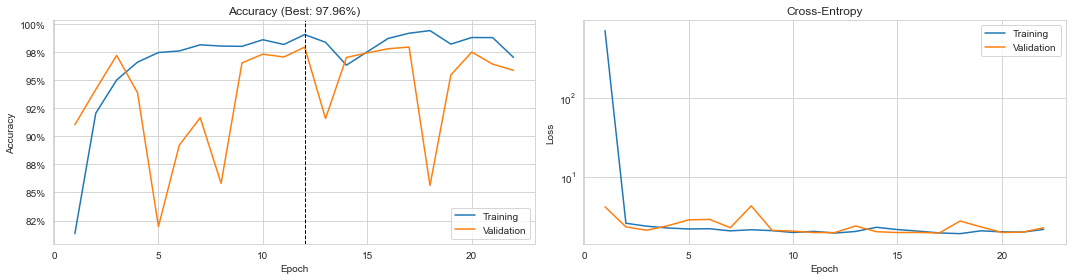

In [41]:
metrics = pd.DataFrame(history.history)
metrics.index = metrics.index.to_series().add(1)

fig, axes = plt.subplots(ncols=2, figsize=(15, 4))
metrics[['accuracy', 'val_accuracy']].plot(ax=axes[0], 
                                           title=f'Accuracy (Best: {metrics.val_accuracy.max():.2%})')
axes[0].axvline(metrics.val_accuracy.idxmax(), ls='--', lw=1, c='k')
metrics[['loss', 'val_loss']].plot(ax=axes[1], title='Cross-Entropy', logy=True)
for ax in axes:
    ax.legend(['Training', 'Validation'])
    ax.set_xlabel('Epoch')
    
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
axes[0].set_ylabel('Accuracy')
axes[1].set_ylabel('Loss')    
fig.tight_layout()
fig.savefig('figures/satellite_accuracy');